<a href="https://colab.research.google.com/github/mswaringen/aml_food/blob/master/Food_Extraction_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install hypopt

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; 
 
# Importing sklearn libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
 
# Importing hypopt library for grid search
from hypopt import GridSearch
 
# Importing Keras libraries
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
 
import warnings
warnings.filterwarnings('ignore')

In [7]:
# download and unzip locally

downzip=True

if downzip:
  !mkdir data
  %cd data
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV" -O final-project-food-recognition-challenge.zip && rm -rf /tmp/cookies.txt
  !unzip final-project-food-recognition-challenge.zip
  %cd ..
  !mkdir outputs

Streaming output truncated to the last 5000 lines.
  inflating: train_set/train_set/train_550.jpg  
  inflating: train_set/train_set/train_5500.jpg  
  inflating: train_set/train_set/train_5501.jpg  
  inflating: train_set/train_set/train_5502.jpg  
  inflating: train_set/train_set/train_5503.jpg  
  inflating: train_set/train_set/train_5504.jpg  
  inflating: train_set/train_set/train_5505.jpg  
  inflating: train_set/train_set/train_5506.jpg  
  inflating: train_set/train_set/train_5507.jpg  
  inflating: train_set/train_set/train_5508.jpg  
  inflating: train_set/train_set/train_5509.jpg  
  inflating: train_set/train_set/train_551.jpg  
  inflating: train_set/train_set/train_5510.jpg  
  inflating: train_set/train_set/train_5511.jpg  
  inflating: train_set/train_set/train_5512.jpg  
  inflating: train_set/train_set/train_5513.jpg  
  inflating: train_set/train_set/train_5514.jpg  
  inflating: train_set/train_set/train_5515.jpg  
  inflating: train_set/train_set/train_5516.jpg  
 

In [8]:
data = [os.path.join("data/train_set/train_set",img) for img in os.listdir("data/train_set/train_set")]

In [9]:
print(len(data))
data[0:5]

30612


['data/train_set/train_set/train_10926.jpg',
 'data/train_set/train_set/train_13506.jpg',
 'data/train_set/train_set/train_28417.jpg',
 'data/train_set/train_set/train_20487.jpg',
 'data/train_set/train_set/train_24697.jpg']

In [10]:
# read the data.csv file and get the image paths and labels
df = pd.read_csv('data/train_labels.csv')
path = 'data/train_set/train_set/'

X = path+df.img_name.values
y = df.label.values - 1
print(X)
print(y)

['data/train_set/train_set/train_1.jpg'
 'data/train_set/train_set/train_2.jpg'
 'data/train_set/train_set/train_3.jpg' ...
 'data/train_set/train_set/train_30610.jpg'
 'data/train_set/train_set/train_30611.jpg'
 'data/train_set/train_set/train_30612.jpg']
[20 28 16 ...  5 20 23]


In [11]:
print(min(y),max(y))

0 79


In [12]:
from sklearn.model_selection import train_test_split

train, test, train_y, test_y = train_test_split(X, y, train_size=0.5, test_size=0.1, random_state=1)

train, val, train_y, val_y = train_test_split(train, train_y, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [13]:
len(train),len(val),len(test)

(11479, 3827, 3062)

In [14]:
len(train_y),len(val_y),len(test_y)

(11479, 3827, 3062)

In [15]:
len(test)/len(X)

0.10002613354240167

In [16]:
train_y = train_y.tolist()
train_y[0:10]

[72, 71, 28, 4, 60, 33, 48, 52, 36, 6]

In [17]:
train[0:10]

array(['data/train_set/train_set/train_2579.jpg',
       'data/train_set/train_set/train_14460.jpg',
       'data/train_set/train_set/train_15971.jpg',
       'data/train_set/train_set/train_28162.jpg',
       'data/train_set/train_set/train_1783.jpg',
       'data/train_set/train_set/train_18936.jpg',
       'data/train_set/train_set/train_14909.jpg',
       'data/train_set/train_set/train_21595.jpg',
       'data/train_set/train_set/train_20590.jpg',
       'data/train_set/train_set/train_29029.jpg'], dtype=object)

In [18]:
num_classes = 80
y_train = np_utils.to_categorical(train_y, num_classes)
y_val = np_utils.to_categorical(val_y, num_classes)
y_test = np_utils.to_categorical(test_y, num_classes)

In [19]:
np.unique(train_y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])

In [20]:
train_y[0:10]

[72, 71, 28, 4, 60, 33, 48, 52, 36, 6]

In [21]:
y_train[0:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

Training data available in 80 classes
[191, 159, 147, 136, 107, 130, 160, 156, 181, 181, 163, 155, 113, 168, 180, 134, 162, 119, 106, 8, 124, 145, 196, 164, 124, 149, 122, 120, 161, 162, 136, 117, 123, 143, 112, 161, 193, 167, 147, 106, 152, 100, 155, 128, 143, 154, 136, 149, 152, 163, 127, 160, 172, 111, 105, 156, 167, 156, 96, 166, 160, 156, 145, 130, 179, 110, 91, 143, 149, 152, 186, 185, 155, 165, 132, 109, 144, 111, 163, 138]


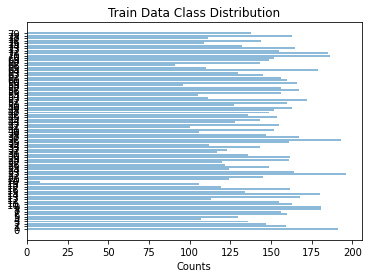

In [22]:
print("Training data available in 80 classes")
print([train_y.count(i) for i in range(0,num_classes)])

food_classes = list(range(80)) 
# food_classes = ('Bread','Dairy product','Dessert','Egg','Fried food','Meat',
#            'Noodles/Pasta','Rice','Seafood', 'Soup', 'Vegetable/Fruit')
 
y_pos = np.arange(len(food_classes))
counts = [train_y.count(i) for i in range(0,num_classes)]
 
plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, food_classes)
plt.xlabel('Counts')
plt.title('Train Data Class Distribution')
plt.show()

In [23]:
def show_imgs(X):
    plt.figure(figsize=(8, 8))
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            image = load_img(train[k], target_size=(224, 224))
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(image)
            k = k+1
    # show the plot
    plt.show()

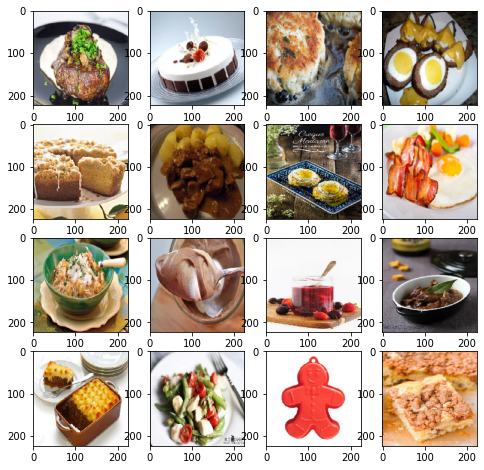

In [24]:
show_imgs(train)

In [25]:
# load the VGG16 network and initialize the label encoder
print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top=False)
model.summary()

[INFO] loading network...
58892288/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
____________________________________

In [26]:
def create_features(dataset, pre_model):
    
    x_scratch = []

    # loop over the images
    for imagePath in dataset:

        # load the input image and image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
        
        # add the image to the batch
        x_scratch.append(image)
        
    x = np.vstack(x_scratch)
    features = pre_model.predict(x, batch_size=32)
    features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))
    return x, features, features_flatten

In [27]:
train_x, train_features, train_features_flatten = create_features(train, model)
val_x, val_features, val_features_flatten = create_features(val, model)
test_x, test_features, test_features_flatten = create_features(test, model)

In [28]:
print(train_x.shape, train_features.shape, train_features_flatten.shape)
print(val_x.shape, val_features.shape, val_features_flatten.shape)
print(test_x.shape, test_features.shape, test_features_flatten.shape)

(11479, 224, 224, 3) (11479, 7, 7, 512) (11479, 25088)
(3827, 224, 224, 3) (3827, 7, 7, 512) (3827, 25088)
(3062, 224, 224, 3) (3062, 7, 7, 512) (3062, 25088)


In [29]:
# Creating a checkpointer 
checkpointer = ModelCheckpoint(filepath='scratchmodel.best.hdf5', 
                               verbose=1,save_best_only=True)

# Building up a Sequential model
model_scratch = Sequential()
model_scratch.add(Conv2D(32, (3, 3), activation='relu',input_shape = train_x.shape[1:]))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(128, (3, 3), activation='relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(GlobalAveragePooling2D())
model_scratch.add(Dense(64, activation='relu'))
model_scratch.add(Dense(80, activation='softmax'))
model_scratch.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       7

In [30]:
y_val.shape

(3827, 80)

In [31]:
val_x.shape

(3827, 224, 224, 3)

In [32]:
model_scratch.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

#Fitting the model on the train data and labels.
history = model_scratch.fit(train_x, y_train, 
          batch_size=32, epochs=10, 
          verbose=1, callbacks=[checkpointer], 
          validation_data=(val_x, y_val), shuffle=True)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 4.4148 - accuracy: 0.0205
Epoch 00001: val_loss improved from inf to 4.24378, saving model to scratchmodel.best.hdf5
359/359 [==============================] - 9s 24ms/step - loss: 4.4148 - accuracy: 0.0205 - val_loss: 4.2438 - val_accuracy: 0.0455
Epoch 2/10
358/359 [============================>.] - ETA: 0s - loss: 4.1009 - accuracy: 0.0519
Epoch 00002: val_loss improved from 4.24378 to 4.04449, saving model to scratchmodel.best.hdf5
359/359 [==============================] - 8s 23ms/step - loss: 4.1006 - accuracy: 0.0519 - val_loss: 4.0445 - val_accuracy: 0.0601
Epoch 3/10
358/359 [============================>.] - ETA: 0s - loss: 3.9064 - accuracy: 0.0800
Epoch 00003: val_loss improved from 4.04449 to 3.92523, saving model to scratchmodel.best.hdf5
359/359 [==============================] - 8s 23ms/step - loss: 3.9060 - accuracy: 0.0800 - val_loss: 3.9252 - val_accuracy: 0.0755
Epoch 4/10
358/359 [===============

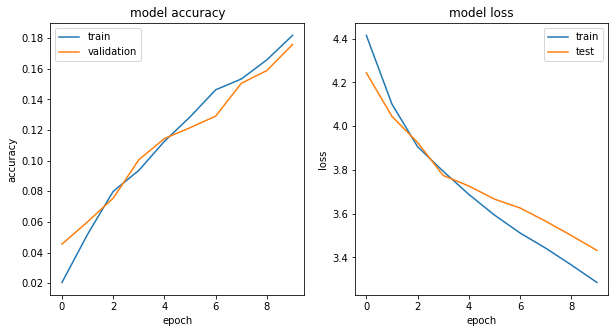

In [38]:
def plot_acc_loss(history):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
 
plot_acc_loss(history)

In [34]:
preds = np.argmax(model_scratch.predict(test_x), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, preds, normalize=False),"\n")
confusion_matrix(test_y, preds, labels=range(0,11))


Accuracy on Test Data:  0.17668190725016328

Number of correctly identified imgaes:  541 



array([[12,  6,  0,  0,  0,  0,  0,  0,  0,  3,  2],
       [ 2, 18,  1,  0,  0,  0,  0,  0,  0,  4,  1],
       [ 1,  4,  5,  0,  0,  0,  1,  0,  0,  2,  0],
       [ 0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  5],
       [ 0,  1,  1,  0,  1,  0,  0,  0,  1,  2,  1],
       [ 1,  1,  1,  0,  0,  4,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 23,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  4, 10,  0,  0,  0],
       [ 0,  4,  0,  0,  0,  1,  3,  0,  6,  0,  0],
       [ 1,  2,  0,  0,  0,  0,  0,  0,  1, 21,  3],
       [ 1,  0,  0,  1,  0,  0,  0,  0,  0,  1, 19]])